In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

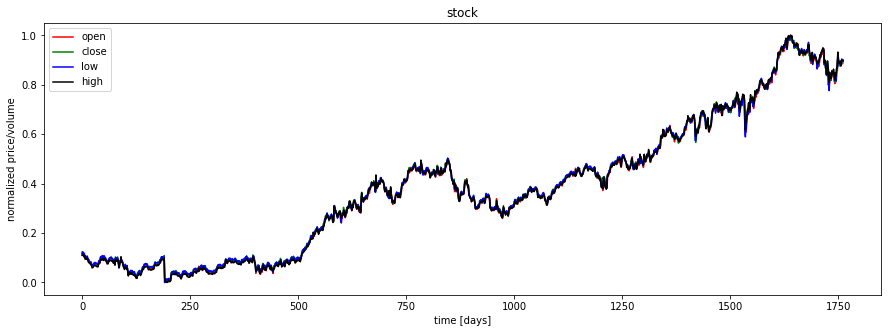

LassoCV Best Alpha Scored:  3.2360382557368727e-05
LassoCV Model Accuracy:  0.9999235832527372
Variables Eliminated:  9
Variables Kept:  3


<Figure size 432x288 with 0 Axes>

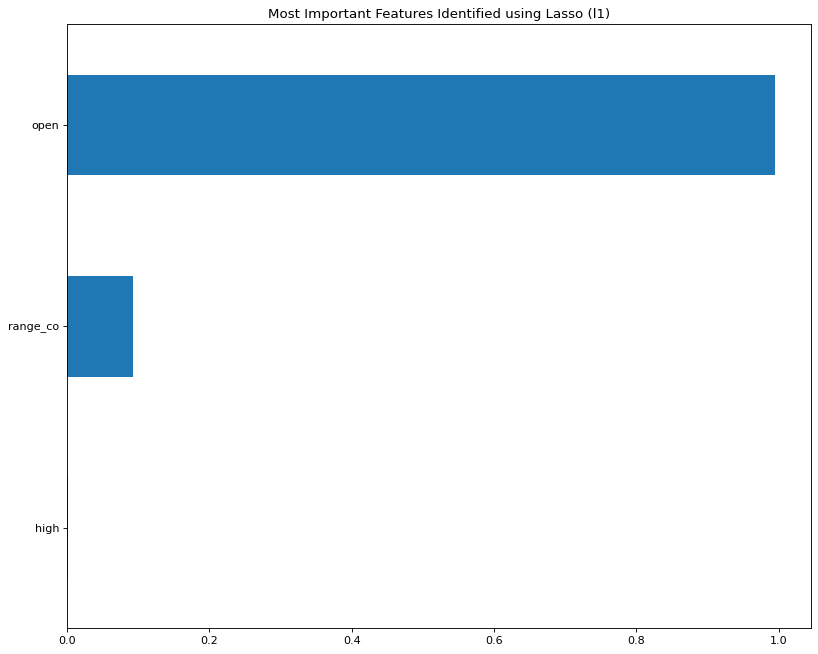

In [3]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

# feature engineering
def add_features(df):
    df['range_hl'] = df['high'] - df['low']
    df['range_co'] = df['close'] - df['open']
    df['cross_hl'] = df['high'] * df['low']
    df['cross_co'] = df['close'] * df['open']
    df['cross_hc'] = df['close'] * df['high']
    df['cross_ho'] = df['close'] * df['open']
    df['cross_lc'] = df['low'] * df['close']
    df['cross_lo'] = df['low'] * df['open']
    return df


def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1, 1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1, 1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1, 1))
    df['volume'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1, 1))
    df['range_hl'] = min_max_scaler.fit_transform(df['range_hl'].values.reshape(-1, 1))
    df['range_co'] = min_max_scaler.fit_transform(df['range_co'].values.reshape(-1, 1))
    df['cross_hl'] = min_max_scaler.fit_transform(df['cross_hl'].values.reshape(-1, 1))
    df['cross_co'] = min_max_scaler.fit_transform(df['cross_co'].values.reshape(-1, 1))
    df['cross_hc'] = min_max_scaler.fit_transform(df['cross_hc'].values.reshape(-1, 1))
    df['cross_ho'] = min_max_scaler.fit_transform(df['cross_ho'].values.reshape(-1, 1))
    df['cross_lc'] = min_max_scaler.fit_transform(df['cross_lc'].values.reshape(-1, 1))
    df['cross_lo'] = min_max_scaler.fit_transform(df['cross_lo'].values.reshape(-1, 1))
    # target
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1, 1))
    return df


# function to create train, validation, test data given stock data and sequence length
def load_data(stock):
    feature_cols = ['open', 'high', 'low', 'volume', 'range_hl',
                    'range_co', 'cross_hl', 'cross_co', 'cross_hc', 'cross_ho'
        , 'cross_lc', 'cross_lo']
    target_col = 'close'

    features = stock[feature_cols].values
    target = stock[target_col].values

    valid_set_size = int(np.round(valid_set_size_percentage / 100 * features.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage / 100 * features.shape[0]))
    train_set_size = features.shape[0] - (valid_set_size + test_set_size)

    x_train = features[:train_set_size, :]
    y_train = target[:train_set_size]

    x_valid = features[train_set_size:train_set_size + valid_set_size, :]
    y_valid = target[train_set_size:train_set_size + valid_set_size]

    x_test = features[train_set_size + valid_set_size:, :]
    y_test = target[train_set_size + valid_set_size:]

    return x_train, y_train, x_valid, y_valid, x_test, y_test

def load_data_df(stock):
    feature_cols = ['open', 'high', 'low', 'volume', 'range_hl',
                    'range_co', 'cross_hl', 'cross_co', 'cross_hc', 'cross_ho'
        , 'cross_lc', 'cross_lo']
    target_col = 'close'
    feature_df = stock[feature_cols]
    target_df = stock[target_col]

    test_set_size = int(round(test_set_size_percentage / 100 * len(feature_df))) * 2
    train_set_size = len(feature_df) -  test_set_size

    x_train = feature_df.iloc[:train_set_size, :]
    y_train = target_df.iloc[:train_set_size]

    x_test = feature_df.iloc[train_set_size:, :]
    y_test = target_df.iloc[train_set_size:]

    return x_train, y_train, x_test, y_test


if __name__=="__main__":
    df = pd.read_csv("data//prices-split-adjusted.csv", index_col = 0)
    # # choose one stock
    df_stock = df[df.symbol == 'EQIX'].copy()
    df_stock.drop(['symbol'], 1, inplace=True)
    df_stock = add_features(df_stock)

    cols = list(df_stock.columns.values)

    # normalize stock
    df_stock_norm = df_stock.copy()
    df_stock_norm = normalize_data(df_stock_norm)
    plt.figure(figsize=(15, 5))
    plt.plot(df_stock_norm.open.values, color='red', label='open')
    plt.plot(df_stock_norm.close.values, color='green', label='close')
    plt.plot(df_stock_norm.low.values, color='blue', label='low')
    plt.plot(df_stock_norm.high.values, color='black', label='high')
    #plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
    plt.title('stock')
    plt.xlabel('time [days]')
    plt.ylabel('normalized price/volume')
    plt.legend(loc='best')
    plt.show()
    plt.savefig('figure/Stock_Price_Curve.png', dpi=400)


    # create train, test data
    X_train, Y_train, X_test, Y_test = load_data_df(df_stock_norm)

    from sklearn.linear_model import LassoCV
    regr = LassoCV(cv=5, random_state=101)
    regr.fit(X_train, Y_train)
    print("LassoCV Best Alpha Scored: ", regr.alpha_)
    print("LassoCV Model Accuracy: ", regr.score(X_test, Y_test))
    model_coef = pd.Series(regr.coef_, index = list(X_train.columns[:]))

    print("Variables Eliminated: ", str(sum(model_coef == 0)))
    print("Variables Kept: ", str(sum(model_coef != 0)))
    # print(model_coef)
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

    top_coef = model_coef.sort_values()
    top_coef[top_coef != 0].plot(kind = "barh")
    plt.title("Most Important Features Identified using Lasso (l1)")
    plt.savefig('figure/Most_Important_Features.jpg', dpi=400)

In [4]:
df_stock_norm

,open,close,low,high,volume,range_hl,range_co,cross_hl,cross_co,cross_hc,cross_ho,cross_lc,cross_lo
date,,,,,,,,,,,,,
2010-01-04,0.109250,0.122904,0.117440,0.110911,0.013934,0.101286,0.685032,0.043589,0.043007,0.044481,0.043007,0.046841,0.043255
2010-01-05,0.118896,0.119708,0.123361,0.110816,0.017405,0.024919,0.554777,0.044977,0.044542,0.043696,0.044542,0.047492,0.046919
2010-01-06,0.116886,0.122810,0.122855,0.113912,0.040928,0.070739,0.606688,0.045586,0.044805,0.045168,0.044805,0.048111,0.046321
2010-01-07,0.117828,0.115791,0.117852,0.113217,0.021195,0.125402,0.525796,0.044222,0.043356,0.043318,0.043356,0.045268,0.045356
2010-01-08,0.110130,0.114161,0.115509,0.103519,0.009204,0.031752,0.587261,0.041423,0.041179,0.040690,0.041179,0.044340,0.043012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,0.880884,0.897089,0.889589,0.895976,0.006104,0.288586,0.731847,0.826760,0.821835,0.833796,0.821835,0.828708,0.814838
2016-12-27,0.895588,0.897433,0.904598,0.900745,0.004674,0.158762,0.586306,0.842132,0.833516,0.837740,0.833516,0.840645,0.837781
2016-12-28,0.896971,0.888471,0.899278,0.900430,0.004576,0.222267,0.481210,0.837731,0.827603,0.830481,0.827603,0.829531,0.834723
